# CheXNet
Uso della CheXNet per migliorare gli embedding e le predizioni.\
Per prima cosa carico la CheXNet dall'architettura DenseNet121 e dai pesi scaricati nella apposita directory.

In [1]:
import numpy as np
import os, pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from keras import models, applications
from keras.api.preprocessing.image import load_img, img_to_array

root = '../..'
dataset_path = f"{root}/datasets/covid_cxr"
dataset_embeddings = f"{dataset_path}_embeddings.npz"
chexnet_path = f"{root}/models/CheXNet.keras"
batch = 32
size = (224, 224)

if not os.path.exists(chexnet_path):
    base = applications.densenet.DenseNet121(weights=None, include_top=True, input_shape=(224,224,3), classes=14)
    base.load_weights(f"{root}/models/weight_only/CheXNet.h5")
    base.save(chexnet_path)

base = models.load_model(chexnet_path, compile=True)

A questo punto carico la CheXNet e predico tutti gli embedding per le immagini.\
Per fare questo devo quindi rimuovere l'ultimo layer per la classificazione.

In [2]:
cheXnet = models.Model(inputs=base.input, outputs=base.layers[-2].output)
for layer in cheXnet.layers: layer.trainable = False

In questo punto carico il dataset e lo trasformo in embedding.\
Nel caso ci sia una cache, essa viene prelevata ed eventualmente modificata in modo da bilanciare le classi o fare ulteriori modifiche.

In [3]:
# Load all the names of the images in one pandas
all_files = []
for t in ['train', 'val', 'test']:
    df = pd.read_csv(f"{dataset_path}/{t}.txt", delimiter=' ', header=None)
    df[1] = df[1].apply(lambda x: f"{dataset_path}/{t}/{x}")
    all_files.append(df)
df = pd.concat(all_files)
df.columns = ['id', 'filename', 'class', 'source']

try:
    ds = np.load(dataset_embeddings, allow_pickle=True)
    embeddings = np.vstack((ds['x_train'], ds['x_val'], ds['x_test']))
    predictions = np.hstack((ds['y_train'], ds['y_val'], ds['y_test']))

    train_tot = len(ds['y_train'])
    val_tot = train_tot + len(ds['y_val'])
    test_tot = val_tot + len(ds['y_test'])

except FileNotFoundError:
    print(f"Dataset embeddings not found at {dataset_embeddings}. Creating new embeddings...")

    # Convert the classes to a numpy array
    predictions = np.array(pd.factorize(df['class'])[0])

    # Create the embeddings for the images
    images = df['filename']
    embeddings = np.zeros((len(images), 1024), dtype="float32")
    img_batch = []
    for i, img_name in enumerate(tqdm(images)):
        img = load_img(img_name, target_size=size, color_mode='rgb')
        img = img_to_array(img)
        img_batch.append(img)
        if len(img_batch) == batch or i == len(images) - 1:
            img_batch = np.array(img_batch)
            batch_embeddings = cheXnet.predict(img_batch, verbose=0)
            embeddings[i - len(img_batch) + 1:i + 1] = batch_embeddings
            img_batch = []

    # Split the dataset into train, validation, and test sets
    train_tot = len(all_files[0])
    val_tot = train_tot + len(all_files[1])
    test_tot = val_tot + len(all_files[2])

print(f"Train: {train_tot}, Validation: {val_tot - train_tot}, Test: {test_tot - val_tot}")

Train: 67863, Validation: 8473, Test: 8482


Qui modifichiamo il dataset, preparandolo per la classificazione.

In [4]:
# shuffle the dataset
indices_train = np.arange(train_tot)
indices_val = np.arange(train_tot, val_tot)
indices_test = np.arange(val_tot, test_tot)
np.random.shuffle(indices_train)
np.random.shuffle(indices_val)
np.random.shuffle(indices_test)
embeddings = np.vstack((embeddings[indices_train], embeddings[indices_val], embeddings[indices_test]))
predictions = np.hstack((predictions[indices_train], predictions[indices_val], predictions[indices_test]))

# remove the test embeddings since they are hard to classify
if test_tot == val_tot + len(all_files[2]):
    embeddings = embeddings[:val_tot]
    predictions = predictions[:val_tot]
    test_tot = val_tot
    val_tot = train_tot + round((val_tot - train_tot) / 2)

# Balance the classes
ranges = (np.arange(0, train_tot), np.arange(train_tot, val_tot), np.arange(val_tot, test_tot))
indices = []
for arange in ranges:
    pred_current = predictions[arange]
    embe_current = embeddings[arange]
    classes = np.bincount(pred_current)
    min_count = np.min(classes)
    ind = []
    for clazz in np.unique(pred_current):
        clazz_index = np.where(pred_current == clazz)[0]
        clazz_index = np.random.choice(clazz_index, min_count, replace=False)
        ind.append(clazz_index)
    indices.append(np.concatenate(ind) + arange[0])

embeddings = np.concatenate((embeddings[indices[0]], embeddings[indices[1]], embeddings[indices[2]]), axis=0)
predictions = np.concatenate((predictions[indices[0]], predictions[indices[1]], predictions[indices[2]]), axis=0)
train_tot = len(indices[0])
val_tot = train_tot + len(indices[1])
test_tot = val_tot + len(indices[2])

train_counts = np.bincount(predictions[:train_tot])
val_counts = np.bincount(predictions[train_tot:val_tot])
test_counts = np.bincount(predictions[val_tot:test_tot])
print(f"Train: {train_tot}, Validation: {val_tot - train_tot}, Test: {test_tot - val_tot}")
print(f"Train counts: {train_counts}, Validation counts: {val_counts}, Test counts: {test_counts}")

Train: 30408, Validation: 1898, Test: 1944
Train counts: [15204 15204], Validation counts: [949 949], Test counts: [972 972]


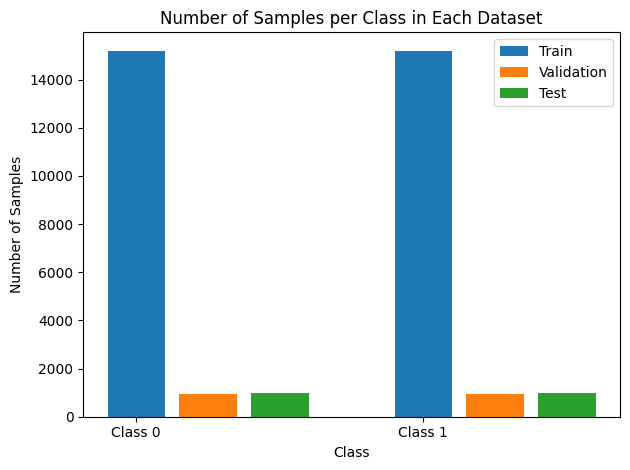

In [5]:
train_counts = np.bincount(predictions[:train_tot])
val_counts = np.bincount(predictions[train_tot:val_tot])
test_counts = np.bincount(predictions[val_tot:test_tot])
total_classes = len(train_counts)

plt.figure()
x_labels = range(total_classes)
plt.bar(x_labels, train_counts, width=0.2, label='Train', align='center')
plt.bar([x + 0.25 for x in x_labels], val_counts, width=0.2, label='Validation', align='center')
plt.bar([x + 0.5 for x in x_labels], test_counts, width=0.2, label='Test', align='center')
plt.xticks(x_labels, [f"Class {i}" for i in x_labels])
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Number of Samples per Class in Each Dataset')
plt.legend()
plt.tight_layout()
plt.show()

In [6]:
# Save the embeddings and predictions to a numpy file
np.savez(
    dataset_embeddings,
    x_train=embeddings[:train_tot],
    y_train=predictions[:train_tot],
    x_val=embeddings[train_tot:val_tot],
    y_val=predictions[train_tot:val_tot],
    x_test=embeddings[val_tot:test_tot],
    y_test=predictions[val_tot:test_tot],
)
print(f"Saved embeddings and predictions to {dataset_embeddings}")

Saved embeddings and predictions to ../../datasets/covid_cxr_embeddings.npz
